In [13]:
# Imports for handling and analysis of TIFF files
from Tesina_Tiff_and_Shapefile_Utils import (
    extract_pixels_within_mask,
    get_raster_info,
    reproject_tiff_files,
    copy_auxiliary_files
)

# Imports for processing shapefiles and manipulating pixel data
from Tesina_Tiff_and_Shapefile_Utils import (
    process_shapefile_data,
    analyze_masks_and_labels,
    enrich_metadata_with_pixel_data,
    reorder_and_select_specific_bands,
    normalize_pixels_globally_with_margin,
    realign_and_filter_pixel_data_by_bands
)

# Imports for recursively printing the structure and content of objects
from Tesina_General_Utils import print_recursive_structure_and_content, find_common_and_uncommon_elements


In [14]:
input_folder = 'data/output/labels/tiff/EPSG_3857/'
output_folder = 'data/output/labels/tiff/'
new_crs = 'EPSG:4326'  # o cualquier otro CRS que necesites

reproject_tiff_files(input_folder, output_folder, new_crs)

In [15]:
metadata_list = process_shapefile_data('data/output/labels', 'EPSG_3857')
analyze_masks_and_labels(metadata_list)
output_enriched = enrich_metadata_with_pixel_data(metadata_list)

Label occurrences:
Quemado: 12 times
Nubes: 16 times
Talado: 15 times
Bosque: 7 times

True values in masks by label:
Quemado: 316263 True values
Nubes: 1541624 True values
Talado: 82230 True values
Bosque: 552283 True values

False values in masks by label:
Quemado: 3259861 False values
Nubes: 1927211 False values
Talado: 2358273 False values
Bosque: 892500 False values


In [16]:
#print_recursive_structure_and_content(output_enriched[0])

In [17]:
selected_bands, uncommon_bands = find_common_and_uncommon_elements(output_enriched, "band_names")
print(f"Common bands: {selected_bands}")
print(f"Uncommon bands: {uncommon_bands}")
#remove "scl" from selected bands
selected_bands.remove("scl")
print(f"Selected bands: {selected_bands}")

Common bands: {'green', 'nir', 'blue', 'scl', 'swir16', 'rededge3', 'swir22', 'rededge1', 'nir08', 'rededge2', 'nir09', 'red'}
Uncommon bands: {'coastal'}
Selected bands: {'green', 'nir', 'blue', 'swir16', 'rededge3', 'swir22', 'rededge1', 'nir08', 'rededge2', 'nir09', 'red'}


In [18]:
output_enriched = realign_and_filter_pixel_data_by_bands(output_enriched, selected_bands)

In [19]:
output_normalized, min_global, max_global = normalize_pixels_globally_with_margin(output_enriched)
print(f"min_global: {min_global}")
print(f"max_global: {max_global}")

min_global: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
max_global: [17362.4 17534.6 16649.5 16781.9 17683.8 16659.1 18132.3 17466.4 17857.3
 17132.4 18453.6]


In [20]:
#print_recursive_structure_and_content(output_normalized[0])

In [21]:
import numpy as np

def calculate_and_normalize_indexs(output_data, index_names, band_names):
    """
    Calculate vegetation indices and normalize them globally across all entries in output_data.

    Parameters:
    - output_data : list of dicts
        Each entry contains 'pixels' which is a list of lists of pixel values for bands.
    - index_names : list of str
        List of vegetation index names to calculate.
    - band_names : list of str
        List of band names used for index calculations.

    Returns:
    - output_data : list of dicts
        The input list of dictionaries, but with an added key 'index' in each
        dictionary containing the calculated index values.
    - normalized_indices : list of lists
        A list of lists where each sublist contains normalized index values for each index.
    """
    band_names = list(band_names)

    # Initialize a list to store normalized index values
    normalized_indices = []
    required_bands = {
        # Vegetation Index Functions
        'NDVI': ['red', 'nir'],
        'NVR': ['red', 'nir', 'blue'],
        'SAVI': ['red', 'nir'],
        'MTCI': ['red', 'nir', 'rededge3'],
        'ARVI': ['red', 'nir', 'blue'],
        'WDVI': ['red', 'nir'],

        # Water Index Functions
        'NDWI': ['green', 'nir'],
        'MNDWI': ['green', 'swir16'],
        'AWEI_sh': ['blue', 'green', 'nir', 'swir16', 'swir22'],
        'WI': ['green', 'blue', 'nir', 'red', 'swir16'],

        # Fire Index Functions
        'NBR': ['nir', 'swir22'],
        'BAI': ['red', 'nir'],
        'AFI': ['swir16', 'swir22'],
        'VFDI': ['nir', 'swir16'],

        # Cloud Index Functions
        'CCI': ['swir16', 'nir'],
        'NDCI': ['green', 'red']
    }

    # Create a dictionary to map index names to calculation functions
    index_functions = {
         # Existing Vegetation Index Functions
        'NDVI': lambda red, nir: (nir - red) / (nir + red),
        'NVR': lambda red, nir, blue: (nir - red) / (nir + red - blue),
        'SAVI': lambda red, nir: ((nir - red) / (nir + red + 0.5)) * (1 + 0.5),
        'MTCI': lambda red, nir, rededge3: (nir - rededge3) / (rededge3 - red) if (rededge3 - red) != 0 else 0,
        'ARVI': lambda red, nir, blue: (nir - (2 * red - blue)) / (nir + (2 * red - blue)),
        'WDVI': lambda red, nir: nir - red,

        # Water Index Functions
        'NDWI': lambda green, nir: (green - nir) / (green + nir),
        'MNDWI': lambda green, swir16: (green - swir16) / (green + swir16),
        'AWEI_sh': lambda blue, green, nir, swir16, swir22: blue + 2.5 * green - 1.5 * (nir + swir16) - 0.25 * swir22,
        'WI': lambda green, blue, nir, red, swir16: green + 2.5 * blue - 1.5 * (nir + red) - 0.25 * swir16,

        # Fire Index Functions
        'NBR': lambda nir, swir22: (nir - swir22) / (nir + swir22),
        'BAI': lambda red, nir: 1.0 / ((0.10 - red) ** 2 + (0.06 - nir) ** 2),
        'AFI': lambda swir16, swir22: (swir22 - swir16) / (swir22 + swir16),
        'VFDI': lambda nir, swir16: (swir16 + nir) / (swir16 - nir),

        # Cloud Index Functions
        'CCI': lambda swir16, nir: (swir16 - nir) / (swir16 + nir),
        'NDCI': lambda green, red: (green - red) / (green + red)
    }

    # Iterate through each entry in output_data
    for entry in output_data:
        pixels = np.array(entry['pixels'])

        # Calcular los valores de índice para cada píxel
        index_values = []
        for pixel_values in pixels:
            calculated_indices = []
            for index_name in index_names:
                try:
                    # Extraer valores de banda necesarios para el índice actual
                    band_vals = {band: pixel_values[band_names.index(band)] for band in required_bands[index_name]}
                    # Calcular el valor del índice usando las bandas extraídas
                    calculated_index = index_functions[index_name](**band_vals)
                except (KeyError, IndexError):
                    # Manejar la falta de bandas necesarias o índices fuera de rango
                    calculated_index = None
                calculated_indices.append(calculated_index)
            index_values.append(calculated_indices)

        # Agregar valores de índice calculados a la entrada
        entry['index'] = index_values

    # Calculate global min and max for each index across all entries
    all_indices = [idx for entry in output_data for idx in entry['index']]
    all_indices = np.array(all_indices)
    min_global = np.min(all_indices, axis=0)
    max_global = np.max(all_indices, axis=0)
    print(max_global)

    # Normalize index values using global min and max
    normalized_indices = (all_indices - min_global) / (max_global - min_global)
            
    # Add normalized index values to each entry in output_data
    index_counter = 0
    for entry in output_data:
        num_pixels = len(entry['pixels'])
        entry['normalized_index'] = normalized_indices[index_counter:index_counter+num_pixels].tolist()
        index_counter += num_pixels
    print(len(normalized_indices))
    return output_data, normalized_indices, min_global, max_global

In [22]:
from Tesina_Indexs_Utils import VegetationIndex, WaterIndex, FireIndex, CloudIndex
index_categories = {
    'Vegetation': [VegetationIndex.NDVI, VegetationIndex.NVR, VegetationIndex.SAVI, VegetationIndex.MTCI, VegetationIndex.ARVI, VegetationIndex.WDVI],
    'Water': [WaterIndex.NDWI, WaterIndex.MNDWI, WaterIndex.AWEI_sh, WaterIndex.WI],
    'Fire': [FireIndex.NBR, FireIndex.BAI, FireIndex.AFI, FireIndex.SAVI],
    'Cloud': [CloudIndex.CCI, CloudIndex.NDCI]
}

#index names from index_categories
index_names = []
for category in index_categories:
    index_names.extend([member.name for member in index_categories[category]])

# Imprime los nombres de los índices
print(f"index_names: {index_names}")

index_names: ['NDVI', 'NVR', 'SAVI', 'MTCI', 'ARVI', 'WDVI', 'NDWI', 'MNDWI', 'AWEI_sh', 'WI', 'NBR', 'BAI', 'AFI', 'SAVI', 'CCI', 'NDCI']


In [23]:
output_normalized, normalized_indices, min_global, max_global = calculate_and_normalize_indexs(output_normalized, index_names, selected_bands)

[1.00000000e+00 3.44444444e+00 1.49855908e+00 1.59500000e+03
 9.53333333e+00 7.95500000e+03 4.93670886e-01 7.23502304e-01
 1.68392500e+04 9.47700000e+03 9.34108527e-01 5.90592941e-04
 2.45467908e-01 1.49855908e+00 8.13643927e-01 1.00000000e+00]
2492400


In [24]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(output_data):
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Extract all labels and fit the LabelEncoder
    labels = [entry['label'] for entry in output_data]
    le.fit(labels)
    
    # Transform the labels and add them to the metadata
    for entry in output_data:
        entry['encoded_label'] = le.transform([entry['label']])[0]

    return output_data, le.classes_

# Now, the encode_labels function will add a new key 'encoded_label' to each entry in output_data.
output_normalized, label_classes = encode_labels(output_normalized)


In [25]:
print (label_classes)
print(output_normalized[5]['encoded_label'])
selected_bands = list(selected_bands)

['Bosque' 'Nubes' 'Quemado' 'Talado']
2


In [26]:
from sklearn.model_selection import train_test_split

# Preparing the data
normalized_pixels = []
indices_normalized = []
combined_pixels_indices = []
labels = []

for entry in output_normalized:
    for pixel_values in entry['pixels_normalized']:
        filtered_pixel = [pixel_values[selected_bands.index(band)] for band in selected_bands]
        normalized_pixels.append(filtered_pixel)
        labels.append(entry['encoded_label'])
    for index in entry['normalized_index']:
        indices_normalized.append(index)
    for pixel_values, index_values in zip(entry['pixels_normalized'], entry['normalized_index']):
        combined = [pixel_values[selected_bands.index(band)] for band in selected_bands] + index_values
        combined_pixels_indices.append(combined)

# Convert to NumPy arrays
X_pixels_normalized = np.array(normalized_pixels)
X_indices_normalized = np.array(indices_normalized)
X_combined = np.array(combined_pixels_indices)
y = np.array(labels)

# Splitting the data for training and testing
X_train_pixels, X_test_pixels, y_train, y_test = train_test_split(X_pixels_normalized, y, test_size=0.2, random_state=42)
X_train_indices, X_test_indices, _, _ = train_test_split(X_indices_normalized, y, test_size=0.2, random_state=42)
X_train_combined, X_test_combined, _, _ = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Print the number of samples
print("Number of samples:", len(y))

# Dictionary for easy access to the datasets
datasets = {
    "normalized_pixels": {
        "train": X_train_pixels,
        "test": X_test_pixels
    },
    "normalized_indices": {
        "train": X_train_indices,
        "test": X_test_indices
    },
    "combined": {
        "train": X_train_combined,
        "test": X_test_combined
    }
}

#shape of the data
print(f"X_train_pixels: {X_train_pixels.shape}")
print(f"X_test_pixels: {X_test_pixels.shape}")
print(f"X_train_indices: {X_train_indices.shape}")
print(f"X_test_indices: {X_test_indices.shape}")
print(f"X_train_combined: {X_train_combined.shape}")
print(f"X_test_combined: {X_test_combined.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

: 

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def train_and_evaluate_model(X_train, X_test, y_train, y_test, model):
    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Calcular métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)

    return report, accuracy

# Diccionario para almacenar los resultados
results = {}

# Lista de modelos a entrenar
models = [RandomForestClassifier(n_jobs=-1), KNeighborsClassifier()]


# Entrenar y evaluar modelos en los tres conjuntos de datos
for model in models:
    model_name = type(model).__name__
    results[model_name] = {}  # Inicializa un sub-diccionario para el modelo
    for dataset_name, dataset in datasets.items():
        report, accuracy = train_and_evaluate_model(dataset['train'], dataset['test'], y_train, y_test, model)
        results[model_name][dataset_name] = {
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score'],
            'Overall Accuracy': accuracy
        }
        print(f"Model: {model_name}, Dataset: {dataset_name}, Accuracy: {accuracy}")
    




Model: RandomForestClassifier, Dataset: normalized_pixels, Accuracy: 0.9980239929385332
Model: RandomForestClassifier, Dataset: normalized_indices, Accuracy: 0.9968644679826673
Model: RandomForestClassifier, Dataset: combined, Accuracy: 0.9976147488364628
Model: KNeighborsClassifier, Dataset: normalized_pixels, Accuracy: 0.9955725405231906
Model: KNeighborsClassifier, Dataset: normalized_indices, Accuracy: 0.9932996308778688
Model: KNeighborsClassifier, Dataset: combined, Accuracy: 0.9946978815599422


In [16]:
print(results)


{'RandomForestClassifier': {'normalized_pixels': {'Precision': 0.9980237203407084, 'Recall': 0.9980239929385332, 'F1-Score': 0.9980217505312854, 'Overall Accuracy': 0.9980239929385332}, 'normalized_indices': {'Precision': 0.9968589787363829, 'Recall': 0.9968644679826673, 'F1-Score': 0.9968570768208945, 'Overall Accuracy': 0.9968644679826673}, 'combined': {'Precision': 0.9976130179750133, 'Recall': 0.9976147488364628, 'F1-Score': 0.9976104043791082, 'Overall Accuracy': 0.9976147488364628}}, 'KNeighborsClassifier': {'normalized_pixels': {'Precision': 0.9955623680934298, 'Recall': 0.9955725405231906, 'F1-Score': 0.9955624458448473, 'Overall Accuracy': 0.9955725405231906}, 'normalized_indices': {'Precision': 0.9932692417048855, 'Recall': 0.9932996308778688, 'F1-Score': 0.9932724048316296, 'Overall Accuracy': 0.9932996308778688}, 'combined': {'Precision': 0.9946794447039101, 'Recall': 0.9946978815599422, 'F1-Score': 0.9946800493182424, 'Overall Accuracy': 0.9946978815599422}}}


In [17]:
import pandas as pd
def plot_results(results):
    metrics = ['Precision', 'Recall', 'F1-Score', 'Overall Accuracy']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))  # Ajuste para un layout 2x2
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        data_to_plot = []
        for model in results:
            for dataset in results[model]:
                data_to_plot.append({
                    'Model': model,
                    'Dataset': dataset,
                    'Metric': metric,
                    'Score': results[model][dataset][metric]
                })
        sns.barplot(x='Model', y='Score', hue='Dataset', data=pd.DataFrame(data_to_plot), ax=axes[i])
        axes[i].set_title(metric)
        axes[i].set_ylim(0.95, 1.01)  # Ajustar los límites del eje Y para una mejor visualización

        # Añadir los puntajes en las barras
        for p in axes[i].patches:
            axes[i].annotate(format(p.get_height(), '.4f'), 
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')

    plt.tight_layout()
    plt.show()


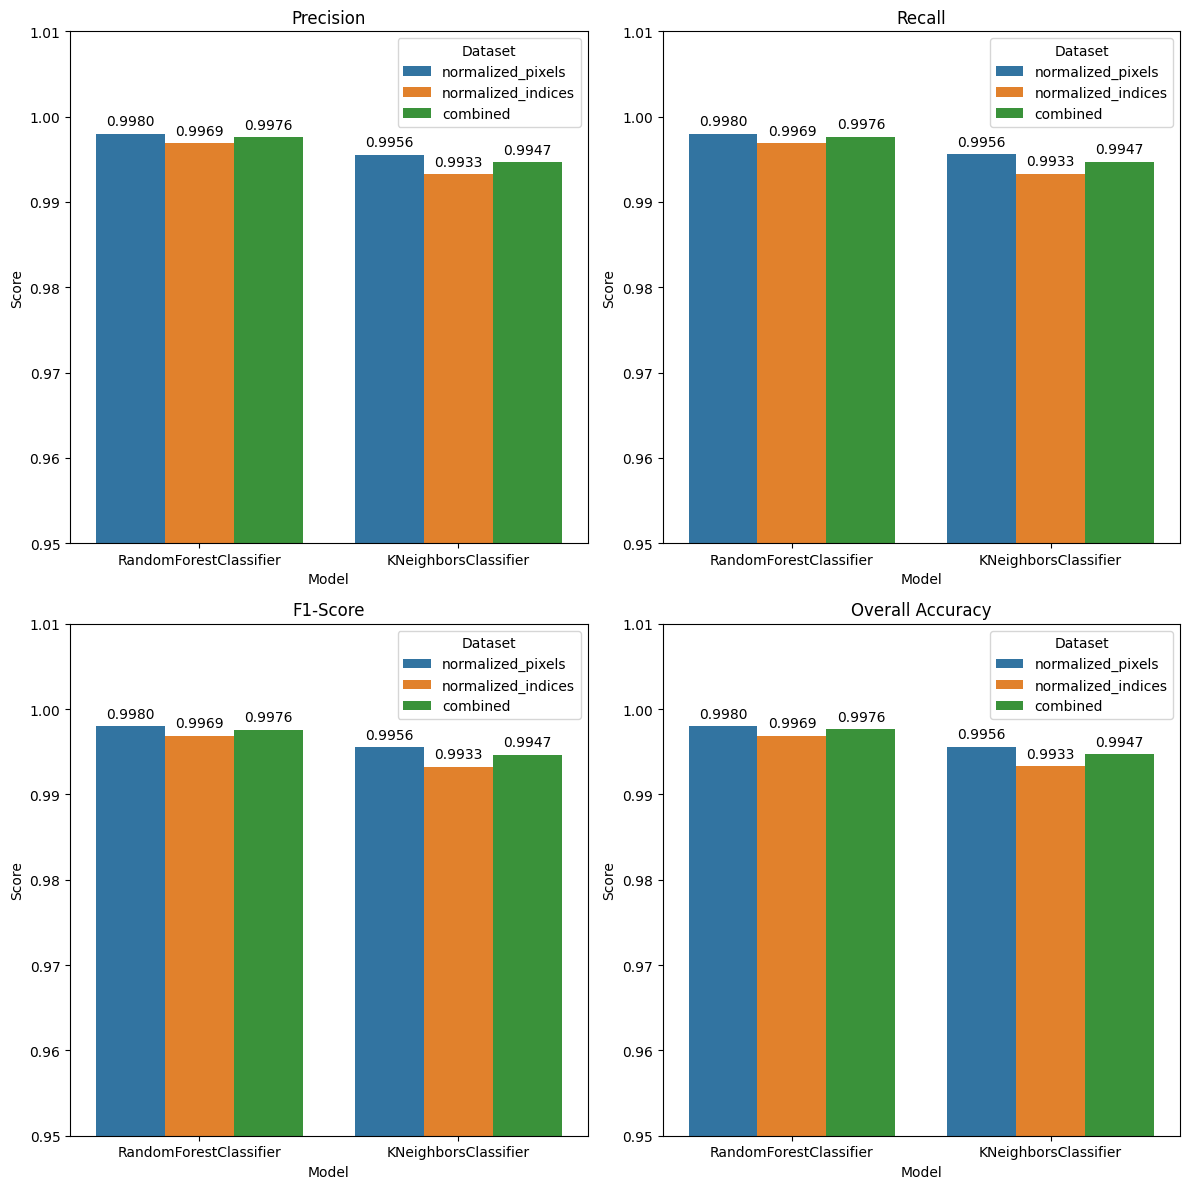

In [18]:
# Graficar los resultados
plot_results(results)

In [ ]:
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier(n_jobs=-1)
rf_scores = cross_val_score(rf_model, X_train_pixels, y_train, cv=5)
print("Random Forest - Precisión en CV:", rf_scores)
print("Random Forest - Precisión Media en CV:", rf_scores.mean())

Random Forest - Precisión en CV: [0.99752748 0.99779831 0.99781586 0.99775317 0.99762277]
Random Forest - Precisión Media en CV: 0.9977035186968383


In [ ]:
knn_model = KNeighborsClassifier()
knn_scores = cross_val_score(knn_model, X_train_pixels, y_train, cv=5)
print("KNN - Precisión en CV:", knn_scores)
print("KNN - Precisión Media en CV:", knn_scores.mean())

KNN - Precisión en CV: [0.99525558 0.99547625 0.99553142 0.99550885 0.9954612 ]
KNN - Precisión Media en CV: 0.995446657839833


In [ ]:
from joblib import dump
import os
from tesina_general_utils import make_dir 

def save_model(model, base_filename, output_path, min_vals=None, max_vals=None, label_classes=None):
    """
    Saves a scikit-learn model to a file.

    :param model: Trained model to be saved.
    :param base_filename: Base filename for saving the model.
    :param output_path: Directory path where the model file will be saved.
    """
    # Ensure the output directory exists
    model_dir = make_dir([output_path])
    model_filename = os.path.join(model_dir, f"{base_filename}_model.joblib")

    model_data = {
        'model': model,
        'min_vals': min_vals,
        'max_vals': max_vals,
        'label_classes': label_classes
    }
    # Save the model
    dump(model_data, model_filename)
    print(f"Model saved to: {model_filename}")

In [ ]:
import json
from datetime import datetime
import numpy as np
import sklearn
import sys
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from pprint import pprint

def save_model_metadata_and_analysis(model, X_train, y_train, X_test, y_test, feature_names, base_filename, output_path, print_info=False):
    """
    Saves metadata and quality analysis of a model to a JSON file.

    :param model: Trained model.
    :param X_train: Training data.
    :param y_train: Training labels.
    :param X_test: Testing data.
    :param y_test: Testing labels.
    :param feature_names: Names of the features.
    :param base_filename: Base filename for saving the metadata and analysis.
    :param output_path: Directory path where the metadata file will be saved.
    """

    
    metadata = {
        'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'model_type': type(model).__name__,
        'model_parameters': model.get_params(),
        'python_version': sys.version,
        'sklearn_version': sklearn.__version__,
        'feature_names': feature_names,
        'class_labels': np.unique(y_test).tolist(),
        'dataset_size': {'train': len(X_train), 'test': len(X_test)}
    }

    # Model analysis
    metadata['training_score'] = model.score(X_train, y_train)
    metadata['test_score'] = model.score(X_test, y_test)
    predictions = model.predict(X_test)
    metadata['classification_report'] = classification_report(y_test, predictions, output_dict=True)

    # AUC and ROC curve (if applicable)
    if hasattr(model, "predict_proba"):
        proba_predictions = model.predict_proba(X_test)
        metadata['roc_auc_score'] = roc_auc_score(y_test, proba_predictions, multi_class='ovr')

    # Feature importances (if applicable)
    if hasattr(model, "feature_importances_"):
        metadata['feature_importances'] = dict(zip(feature_names, model.feature_importances_))

    # Cross-validation scores
    # Aquí puedes ajustar los parámetros de cv y scoring según tus necesidades
    metadata['cross_validation_scores'] = cross_val_score(model, X_train, y_train, cv=5).tolist()
    
    # Print information if required
    if print_info:
        pprint(metadata)

    if base_filename:
        metadata_dir = make_dir([output_path])
        metadata_filename = os.path.join(metadata_dir, f"{base_filename}_metadata.json")
        with open(metadata_filename, 'w') as file:
            json.dump(metadata, file, indent=4)
        print(f"Metadata and model analysis saved to: {metadata_filename}")

In [ ]:
model_name ='random_forest_pixels_4_labels'
save_model(rf_model, model_name, 'data/output/models/', min_vals=min_global, max_vals=max_global, label_classes=label_classes)
save_model_metadata_and_analysis(rf_model, X_train_pixels, y_train, X_test_pixels, y_test, selected_bands, model_name, 'data/output/models/', print_info=True)

In [ ]:
model_name ='knn_pixels_4_labels'
save_model(knn_model, model_name, 'data/output/models/', min_vals=min_global, max_vals=max_global, label_classes=label_classes)
save_model_metadata_and_analysis(knn_model, X_train_pixels, y_train, X_test_pixels, y_test, selected_bands, model_name, 'data/output/models/', print_info=True)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cloud_label_encoded = 1

# Filtrar los datos
mask = y_train != cloud_label_encoded
X_train_pixels_no_clouds = X_train_pixels[mask]
y_train_no_clouds = y_train[mask]

# Entrenar el modelo sin la etiqueta 'Nubes'
rf_model_no_clouds = RandomForestClassifier(n_jobs=-1)
rf_model_no_clouds.fit(X_train_pixels_no_clouds, y_train_no_clouds)

# Filtrar el conjunto de prueba y predecir
mask_test = y_test != cloud_label_encoded
X_test_pixels_no_clouds = X_test_pixels[mask_test]
y_test_no_clouds = y_test[mask_test]
y_pred_no_clouds = rf_model_no_clouds.predict(X_test_pixels_no_clouds)
conf_matrix_no_clouds = confusion_matrix(y_test[mask_test], y_pred_no_clouds)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# Comparación entre modelos y generación del gráfico
def compare_models_and_plot(models, X_train, y_train):
    results = {}
    precisions = {}

    for model in models:
        model_name = type(model).__name__
        scores = cross_val_score(model, X_train, y_train, cv=5)
        results[model_name] = scores.mean()
        precisions[model_name] = scores 

    # Crear un DataFrame para el gráfico
    df = pd.DataFrame(precisions)

    # Crear un gráfico de caja
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df)
    plt.title('Distribución de la Precisión en la Validación Cruzada')
    plt.ylabel('Precisión')
    plt.show()

    return results

# Comparar modelos
models = [RandomForestClassifier(n_jobs=-1), KNeighborsClassifier()]
results = compare_models_and_plot(models, X_train_pixels, y_train)
print(results)



KeyError: 'RandomForestClassifier'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train with all labels
rf_model_all = RandomForestClassifier(n_jobs=-1)
rf_model_all.fit(X_train_pixels, y_train)

# Predict on the test set
y_pred_all = rf_model_all.predict(X_test_pixels)


In [ ]:
cloud_label_encoded = 1

# Filtrar los datos
mask = y_train != cloud_label_encoded
X_train_pixels_no_clouds = X_train_pixels[mask]
y_train_no_clouds = y_train[mask]

# Entrenar el modelo sin la etiqueta 'Nubes'
rf_model_no_clouds = RandomForestClassifier(n_jobs=-1)
rf_model_no_clouds.fit(X_train_pixels_no_clouds, y_train_no_clouds)

# Filtrar el conjunto de prueba y predecir
mask_test = y_test != cloud_label_encoded
X_test_pixels_no_clouds = X_test_pixels[mask_test]
y_test_no_clouds = y_test[mask_test]
y_pred_no_clouds = rf_model_no_clouds.predict(X_test_pixels_no_clouds)
conf_matrix_no_clouds = confusion_matrix(y_test[mask_test], y_pred_no_clouds)


In [ ]:
print("Reporte de Clasificación - Todas las Etiquetas:\n", classification_report(y_test, y_pred_all))
print("Reporte de Clasificación - Sin Nubes:\n", classification_report(y_test_no_clouds, y_pred_no_clouds))

from sklearn.metrics import accuracy_score

# Exactitud para el modelo con todas las etiquetas (rf_model_all)
accuracy_model_all = accuracy_score(y_test, rf_model_all.predict(X_test_pixels))

# Exactitud para el modelo sin 'Nubes' (rf_model_no_clouds)
# Asegúrate de usar el conjunto de prueba ajustado que excluye 'Nubes'
accuracy_model_no_clouds = accuracy_score(y_test_no_clouds, rf_model_no_clouds.predict(X_test_pixels_no_clouds))

print(f"Exactitud del modelo con todas las etiquetas: {accuracy_model_all}")
print(f"Exactitud del modelo sin 'Nubes': {accuracy_model_no_clouds}")


Reporte de Clasificación - Todas las Etiquetas:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    110075
           1       1.00      1.00      1.00    308613
           2       0.99      1.00      1.00     63349
           3       0.99      0.98      0.98     16443

    accuracy                           1.00    498480
   macro avg       1.00      0.99      0.99    498480
weighted avg       1.00      1.00      1.00    498480

Reporte de Clasificación - Sin Nubes:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    110075
           2       0.99      1.00      1.00     63349
           3       0.99      0.98      0.98     16443

    accuracy                           1.00    189867
   macro avg       0.99      0.99      0.99    189867
weighted avg       1.00      1.00      1.00    189867

Exactitud del modelo con todas las etiquetas: 0.9980059380516771
Exactitud del modelo sin 'Nubes

In [ ]:
# Predicción con el modelo entrenado con todas las etiquetas
y_pred_all_no_clouds = rf_model_all.predict(X_test_pixels_no_clouds)

# Matriz de confusión para el modelo entrenado con todas las etiquetas
conf_matrix_all_no_clouds = confusion_matrix(y_test_no_clouds, y_pred_all_no_clouds)

# Matriz de confusión para el modelo entrenado sin 'Nubes'
conf_matrix_no_clouds = confusion_matrix(y_test_no_clouds, y_pred_no_clouds)


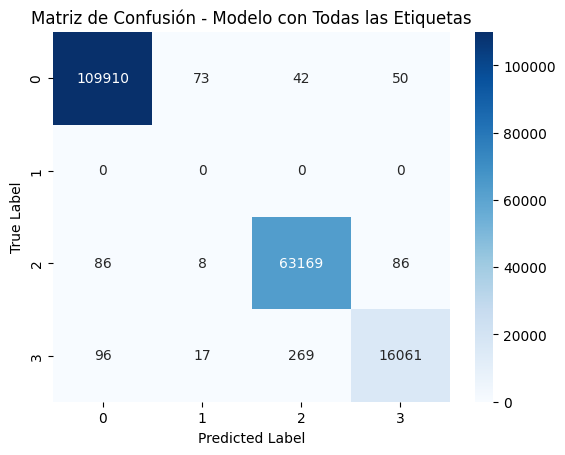

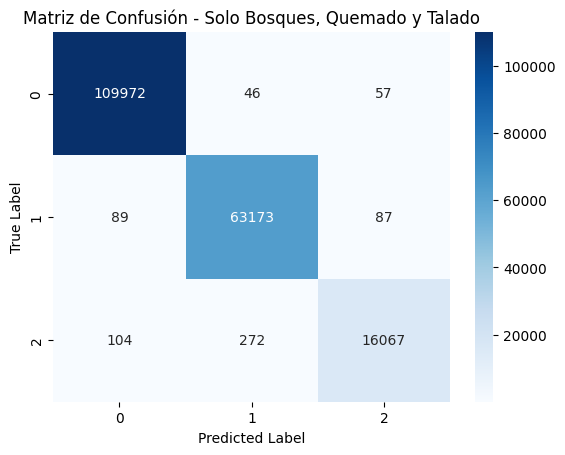

In [ ]:
# Matriz de Confusión - Modelo con Todas las Etiquetas
sns.heatmap(conf_matrix_all_no_clouds, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Modelo con Todas las Etiquetas')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Matriz de Confusión - Modelo sin 'Nubes'
sns.heatmap(conf_matrix_no_clouds, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Solo Bosques, Quemado y Talado')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


/home/jvl/tesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Modelo con todas las etiquetas - Accuracy: 0.9961710039132656, Recall: 0.7431069623205729, F1: 0.7446706178188713
Modelo sin 'Nubes' - Accuracy: 0.9965502167306588, Recall: 0.9911397136007342, F1: 0.9929455996677695


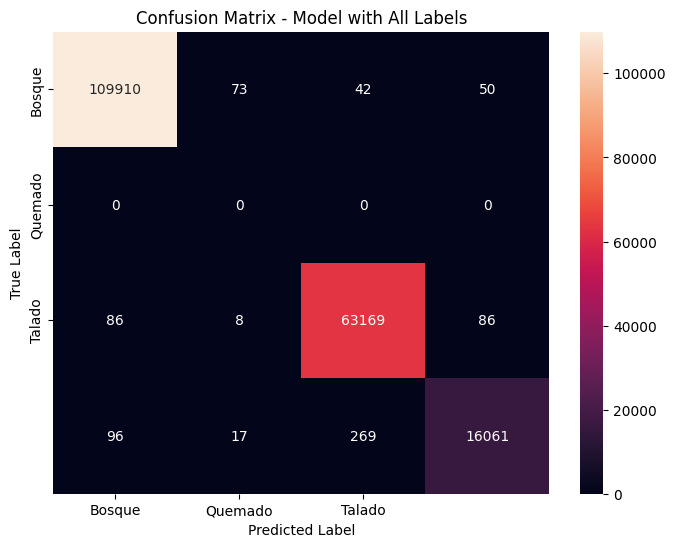

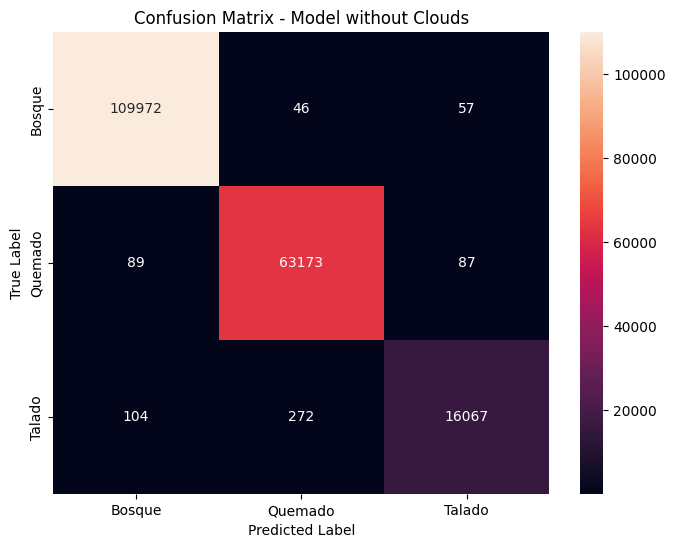

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluar el modelo entrenado con todas las etiquetas
y_pred_all_no_clouds = rf_model_all.predict(X_test_pixels_no_clouds)
accuracy_all = accuracy_score(y_test_no_clouds, y_pred_all_no_clouds)
recall_all = recall_score(y_test_no_clouds, y_pred_all_no_clouds, average='macro')
f1_all = f1_score(y_test_no_clouds, y_pred_all_no_clouds, average='macro')

# Evaluar el modelo entrenado sin 'Nubes'
y_pred_no_clouds = rf_model_no_clouds.predict(X_test_pixels_no_clouds)
accuracy_no_clouds = accuracy_score(y_test_no_clouds, y_pred_no_clouds)
recall_no_clouds = recall_score(y_test_no_clouds, y_pred_no_clouds, average='macro')
f1_no_clouds = f1_score(y_test_no_clouds, y_pred_no_clouds, average='macro')

# Imprimir las métricas
print(f"Modelo con todas las etiquetas - Accuracy: {accuracy_all}, Recall: {recall_all}, F1: {f1_all}")
print(f"Modelo sin 'Nubes' - Accuracy: {accuracy_no_clouds}, Recall: {recall_no_clouds}, F1: {f1_no_clouds}")

# Matrices de confusión
adjusted_labels = [label for label in label_classes if label != 'Nubes']

# Matriz de Confusión - Modelo con Todas las Etiquetas
conf_matrix_all_no_clouds = confusion_matrix(y_test_no_clouds, y_pred_all_no_clouds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_all_no_clouds, annot=True, fmt='d', xticklabels=adjusted_labels, yticklabels=adjusted_labels)
plt.title('Confusion Matrix - Model with All Labels')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Matriz de Confusión - Modelo sin 'Nubes'
conf_matrix_no_clouds = confusion_matrix(y_test_no_clouds, y_pred_no_clouds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_no_clouds, annot=True, fmt='d', xticklabels=adjusted_labels, yticklabels=adjusted_labels)
plt.title('Confusion Matrix - Model without Clouds')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




In [ ]:
import time
# Tiempo de predicción para el modelo con todas las etiquetas
start_time = time.time()
y_pred_all_no_clouds = rf_model_all.predict(X_test_pixels_no_clouds)
end_time = time.time()
time_pred_all = end_time - start_time
print(f"Tiempo de predicción (Modelo con todas las etiquetas): {time_pred_all} segundos")

# Tiempo de predicción para el modelo sin 'Nubes'
start_time = time.time()
y_pred_no_clouds = rf_model_no_clouds.predict(X_test_pixels_no_clouds)
end_time = time.time()
time_pred_no_clouds = end_time - start_time
print(f"Tiempo de predicción (Modelo sin 'Nubes'): {time_pred_no_clouds} segundos")


Tiempo de predicción (Modelo con todas las etiquetas): 0.47452616691589355 segundos
Tiempo de predicción (Modelo sin 'Nubes'): 0.3936636447906494 segundos


: 

In [ ]:
# Preparing data without clouds
normalized_pixels_non_cloud = []
indices_normalized_non_cloud = []
combined_pixels_indices_non_cloud = []
labels_non_cloud = []

for entry in non_cloud_data:
    for pixel_values in entry['pixels_normalized']:
        filtered_pixel = [pixel_values[selected_bands.index(band)] for band in selected_bands]
        normalized_pixels_non_cloud.append(filtered_pixel)
        labels_non_cloud.append(entry['encoded_label'])
    for index in entry['normalized_index']:
        indices_normalized_non_cloud.append(index)
    for pixel_values, index_values in zip(entry['pixels_normalized'], entry['normalized_index']):
        combined = [pixel_values[selected_bands.index(band)] for band in selected_bands] + index_values
        combined_pixels_indices_non_cloud.append(combined)

# Convert to NumPy arrays
X_pixels_normalized_non_cloud = np.array(normalized_pixels_non_cloud)
X_indices_normalized_non_cloud = np.array(indices_normalized_non_cloud)
X_combined_non_cloud = np.array(combined_pixels_indices_non_cloud)
y_non_cloud = np.array(labels_non_cloud)

# Splitting data for training and testing
X_train_pixels_nc, X_test_pixels_nc, y_train_nc, y_test_nc = train_test_split(X_pixels_normalized_non_cloud, y_non_cloud, test_size=0.2, random_state=42)
X_train_indices_nc, X_test_indices_nc, _, _ = train_test_split(X_indices_normalized_non_cloud, y_non_cloud, test_size=0.2, random_state=42)
X_train_combined_nc, X_test_combined_nc, _, _ = train_test_split(X_combined_non_cloud, y_non_cloud, test_size=0.2, random_state=42)


#shape of the data
print(f"X_train_pixels: {X_train_pixels_nc.shape}")
print(f"X_test_pixels: {X_test_pixels_nc.shape}")
print(f"X_train_indices: {X_train_indices_nc.shape}")
print(f"X_test_indices: {X_test_indices_nc.shape}")
print(f"X_train_combined: {X_train_combined_nc.shape}")
print(f"X_test_combined: {X_test_combined_nc.shape}")
print(f"y_train: {y_train_nc.shape}")
print(f"y_test: {y_test_nc.shape}")


RandomForestClassifier(n_jobs=-1)

In [ ]:
# Train and evaluate models on three data sets without clouds
results_non_cloud = {}

for model in models:
    model_name = type(model).__name__
    results_non_cloud[model_name] = {}  # Initialize a sub-dictionary for the model
    datasets_non_cloud = {
        "normalized_pixels": {
            "train": X_train_pixels_nc,
            "test": X_test_pixels_nc
        },
        "normalized_indices": {
            "train": X_train_indices_nc,
            "test": X_test_indices_nc
        },
        "combined": {
            "train": X_train_combined_nc,
            "test": X_test_combined_nc
        }
    }
    for dataset_name, dataset in datasets_non_cloud.items():
        report, accuracy = train_and_evaluate_model(dataset['train'], dataset['test'], y_train_nc, y_test_nc, model)
        results_non_cloud[model_name][dataset_name] = {
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score'],
            'Overall Accuracy': accuracy
        }
        print(f"Model: {model_name}, Dataset: {dataset_name}, Accuracy: {accuracy}")


In [ ]:
# Compare results
print("Results with clouds included:")
plot_results(results)  # Using the plot_results function from before

print("Results without clouds:")
plot_results(results_non_cloud)


In [ ]:
model_name = 'random_forest'
save_model(rf_model, model_name, 'data/output/models/', min_vals=min_global, max_vals=max_global, label_classes=label_classes)
save_model_metadata_and_analysis(rf_model, X_train, y_train, X_test, y_test, x_names, model_name, 'data/output/models/', print_info=True)

Model saved to: data/output/models/random_forest_model.joblib
{'class_labels': [0, 1, 2, 3],
 'classification_report': {'0': {'f1-score': 0.9975813733987375,
                                 'precision': 0.9965729206331937,
                                 'recall': 0.9985918691801045,
                                 'support': 110075.0},
                           '1': {'f1-score': 0.9994263025686736,
                                 'precision': 0.9997114483670896,
                                 'recall': 0.9991413193870641,
                                 'support': 308613.0},
                           '2': {'f1-score': 0.9955947136563877,
                                 'precision': 0.9940671031096563,
                                 'recall': 0.9971270264723989,
                                 'support': 63349.0},
                           '3': {'f1-score': 0.9838867785810562,
                                 'precision': 0.9912351089438923,
                              

In [ ]:
from sklearn.feature_selection import SelectFromModel
feature_selector = SelectFromModel(rf_model, threshold=-np.inf, prefit=True)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#Evaluar el modelo
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_classes))
print("Accuracy:", accuracy_score(y_test, y_pred))
feature_importance = rf_model.feature_importances_

if(len(selected_bands) == len(feature_importance)):
    feature_importance = [(selected_bands[i], importance) for i, importance in enumerate(feature_importance)]
    feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    print("Características más importantes:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance}")
elif (len(index_names) == len(feature_importance)):
    feature_importance = [(index_names[i], importance) for i, importance in enumerate(feature_importance)]
    feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    print("Características más importantes:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance}")
elif len(x_names) == len(feature_importance):
    feature_importance = [(x_names[i], importance) for i, importance in enumerate(feature_importance)]
    feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    print("Características más importantes:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance}")

              precision    recall  f1-score   support

      Bosque       1.00      1.00      1.00    110075
       Nubes       1.00      1.00      1.00    308613
     Quemado       0.99      1.00      1.00     63349
      Talado       0.99      0.98      0.98     16443

    accuracy                           1.00    498480
   macro avg       1.00      0.99      0.99    498480
weighted avg       1.00      1.00      1.00    498480

Accuracy: 0.998052078318087
Características más importantes:
blue: 0.19346516579727446
red: 0.16845536716196285
green: 0.16343033771070578
nir09: 0.1267514015146926
rededge1: 0.08490453495899053
swir22: 0.07193643095197158
rededge2: 0.05923310593034659
rededge3: 0.04598637319173889
nir08: 0.035186241717828984
swir16: 0.03337263865702358
nir: 0.017278402407464036


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}



In [ ]:
rf = RandomForestClassifier()

# Utiliza RandomizedSearchCV para búsqueda aleatoria
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=6)

# O utiliza GridSearchCV para búsqueda exhaustiva
# grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Ajusta el modelo a tus datos de entrenamiento
random_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.5s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.7s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.9s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.9s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   2.0s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.992 total time=21.1min
[CV 2/5] END bootstrap

/home/jvl/tesis/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.997 total time=88.4min
[CV 1/5] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.997 total time=23.7min
[CV 3/5] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.997 total time=83.1min
[CV 1/5] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=nan total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=nan total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=nan total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4

: 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Supongamos que tienes tus etiquetas reales en y_test y las predicciones en y_pred
confusion_mat = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Utiliza seaborn para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

    

In [ ]:
from sklearn.model_selection import GridSearchCV

# Entrenar Regresión Logística
log_reg_model = LogisticRegression(max_iter=100000)
best_params = {'C': 10.0, 'fit_intercept': True, 'penalty': 'l2'}
log_reg_model_best = LogisticRegression(**best_params)
log_reg_model.fit(X_train, y_train)
log_reg_model_best.fit(X_train, y_train)


In [ ]:

# Definir la cuadrícula de hiperparámetros para la búsqueda
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['None', 'l2'],
    'fit_intercept': [True, False]
}

# Realizar la búsqueda de hiperparámetros usando validación cruzada
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros para la Regresión Logística:")
print(grid_search.best_params_)


In [ ]:
# Evaluación
for model, name in zip([log_reg_model, rf_model, log_reg_model_best], ["Logistic Regression", "Random Forest", "Logistic Regression Best"]):
    y_pred = model.predict(X_test)
    print(f"Evaluation of {name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))